# A brief introduction to JAX

Google JAX is a high-performance, open-source numerical computing library with a NumPy-like API that is notable for the following features.
- **XLA compilation:** JAX allows certain Python functions to be compiled more efficiently using XLA.
- **Hardware acceleration:** In addition to the CPU, JAX seamlessly integrates with GPUs and TPUs.
- **Differentiable Programming:** JAX comes with high-performance automatic differentiation.

This tutorial is meant to give you a brief introduction to JAX and is structured as follows.

- [An accelerated NumPy](#an-accelerated-numpy)
- [Useful higher-order functions](#useful-higher-order-functions)
- [PyTrees](#pytrees)


## An accelerated NumPy <a name="an-accelerated-numpy"></a>

A major appeal of JAX is that its API is largely based on the highly prevalent scientific computing library NumPy.
As a consequence, many programs would run just as well in JAX if we replaced `np` with `jnp`.
Let's look at a few lines of code written in JAX, to illustrate this:


In [1]:
import jax
import jax.numpy as jnp
import numpy as np

x = jnp.linspace(0, 5, 11)
x

Array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ], dtype=float32)

In [2]:
unit_circle_arr = jnp.sin(x) ** 2 + jnp.cos(x) ** 2
print(jnp.round(jnp.mean(unit_circle_arr), 7))

1.0


Apart from the standard float size of 32 bits, this looks like good old NumPy!


### Purely functional programming and the difference between JAX and NumPy

To understand the nuances between NumPy and JAX, it is important to note that many of the benefits of plain JAX only really manifest themselves when code is written in a **purely functional** paradigm,
i.e. programs that are constructed by applying and composing pure functions.

#### Pure functions

A function is said to be "pure" if its **return value is determined solely by its input parameters** and it has **no side effects**.
A side effect is any effect of a function that isn't returned in its output.
Modifying an object passed to the function is an example of a side effect.
Pure functions have distinct properties that are conducive to advanced optimisations,
which is, of course, in line with JAX's primary goal of improving performance.

#### Array modifications
Let's look at a case NumPy's impure implementation leads to differing behavior between JAX and NumPy:


In [3]:
def sort_array(arr, library_name: str = "") -> None:
    return_arr = arr.sort()
    print(f"{library_name:>5s}:  arr = {arr}, return_arr = {return_arr}")


sort_array(np.array([2, 1, 0]), library_name="numpy")
sort_array(jnp.array([2, 1, 0]), library_name="jax")

numpy:  arr = [0 1 2], return_arr = None
  jax:  arr = [2 1 0], return_arr = [0 1 2]


We notice that while `arr.sort()` changes the array in place in the case of NumPy, JAX returns a sorted copy of the array, leaving the original unchanged.

One of the most common cases where the difference in API between JAX and NumPy becomes noticeable is when an array is modified in place using indices.
The JAX counterpart to `array[index] = value` is `array.at[index].set(value)`.
But unlike in NumPy, JAX creates and returns a new array with the corresponding modifications made:

In [4]:
x_old = jnp.zeros(1)

# The NumPy equivalent x_old[0] = 1 would throw a TypeError
x_new = x_old.at[0].set(1)

print(f"x_new = {x_new}, while x_old = {x_old} remains unchanged.")

x_new = [1.], while x_old = [0.] remains unchanged.


> **Remark**: JAX computations are often compiled before being run using `jax.jit()`, which we will introduce below.
> If we don’t use the old array after modifying it in place using indexed update operators,
> the compiler can recognise that it can in fact compile to an in-place modify,
> ultimately resulting in a more memory efficient code than would be expected from examining the above behaviour.

#### Random number generation

Another violation of the principle of pure functions would be for a function to depend indirectly on the state of a global pseudorandom number generator (PRNG). 
For this reason, the approach to pseudorandom number generation in JAX differs slightly from that in NumPy:

In [5]:
# To generate random numbers you need a PRNG key
key = jax.random.PRNGKey(seed=42)
print(f"Initial key = {key}")

# You can split this key into a `subkey` when needed
key, subkey = jax.random.split(key)
print(f"Key after split = {key}")
print(f"Subkey = {subkey}")

# Generate an array of random numbers
random_jnp = jax.random.uniform(key=subkey, shape=(5,))

Initial key = [ 0 42]
Key after split = [2465931498 3679230171]
Subkey = [255383827 267815257]


## Useful higher-order functions <a name="useful-higher-order-functions"></a>

JAX comes with a number of higher-order functions that take a function as an input and transform it into a different function.
These functions are useful when writing numeric code and often lead to performance gains.

In the following, we will introduce the following higher-order functions

- `jit()`, for compiling your Python code, boosting performance in many cases.
- `grad()`, for computing gradients of functions with respect to their inputs.
- `vmap()`, for automatic vectorization or batching.


### Just In Time Compilation with `jax.jit()`

`jax.jit()` provides Just In Time (JIT) compilation of pure Python functions into an intermediate language called **JAX expression (jaxpr)**.
It does so by tracing a function to determine its effect on inputs of a specific shape and type.

#### jaxpr, XLA and traicing

jaxpr serves as the interface between the high-level functional programming constructs of JAX and the low-level optimisations and execution strategies provided by XLA.
**XLA**, or Accelerated Linear Algebra, is a very fast compiler that forms the basis of what makes JAX uniquely powerful and easy to use on various hardware platforms. More precisely, XLA is a graph-based, just-in-time compiler for linear algebra operations. It significantly increases execution speed and reduces memory usage through a variety of optimisations, notably the fusion of low-level operations.

We can examine the jaxpr translation of a python function using `jax.make_jaxpr()`.
Although reading jaxpr provides a deeper understanding of JAX as a framework,
understanding it is not a prerequisite for using JAX, and a thorough introduction to jaxpr would be beyond the scope of this introductory tutorial.
What is very useful to know, however, is that JAX builds the jaxpr of a Python function using a process called **tracing**:
During tracing, JAX encapsulates each argument with a tracer object,
which allows JAX operations to be recorded as the function is called within regular Python.
These recorded operations are then used by JAX to reconstruct the function,
resulting in the jaxpr translation of the function.

Let's compile the following function, to illustrate how the tracing works:


In [6]:
@jax.jit
def add_one(x: jax.Array) -> jax.Array:
    print("I'm being traced!")
    y = x + 1
    return y


print("First call")
print("Result:", add_one(jnp.array([0.0])))

print("\nSubsequent call with array of the same shape")
print("Result:", add_one(jnp.array([0.0])))

print("\nSubsequent call with array of different shape")
print("Result:", add_one(jnp.array([1.0, 2.0, 3.0])))

First call
I'm being traced!
Result: [1.]

Subsequent call with array of the same shape
Result: [1.]

Subsequent call with array of different shape
I'm being traced!
Result: [2. 3. 4.]


Note that JAX was able to compile this function successfully, despite the presence of an impurity introduced by the print statement.
However, it's important to realise that the behaviour of the compiled function differs from that of the original Python function, as it no longer executes the print statement.
Note also that the function will be retraced if the shape of the input array is changed.

Lets look at the speed-up we can achieve, when compiling a function that requires a little more advanced computation executed multiple times:


In [7]:
def selu(x: jax.Array, alpha: float = 1.1, lmbda: float = 1.05) -> jax.Array:
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(0, 10, 10)

# Without jit compilation
%timeit -n 2000 selu(x).block_until_ready()

# With jit compilation
selu_jit = jax.jit(selu)
%timeit -n 2000 selu_jit(x).block_until_ready()

31.1 µs ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 2,000 loops each)
3.41 µs ± 2.05 µs per loop (mean ± std. dev. of 7 runs, 2,000 loops each)


Naturally, we aim to convert as many computations as possible into jaxpr format to take advantage of the optimisation capabilities of the XLA compiler.
However, it's important to note that converting a function to jaxpr will typically only save time if the function is computationally intensive or if it needs to be executed multiple times.
Otherwise, the compilation overhead may outweigh the performance benefits.


In [8]:
# Compilation time
%timeit -n 1 -r 1 selu_jit = jax.jit(selu)

94.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


There are many more elaborate examples that could be used to illustrate the efficiency gains achieved by using JAX.
However, to keep the execution time of this notebook to a minimum, we will not explore this further and encourage the curious reader to do so themselves.


#### Limitations

Not all JAX code can be JIT compiled, as it requires array shapes to be static and known at compile time.
Let's look at an example where `jax.jit` fails:


In [9]:
@jax.jit
def naive_relu(x: float) -> float:
    if x > 0:
        return x
    else:
        return 0


try:
    naive_relu(10)
except Exception as ex:
    print(f"{type(ex).__name__}")

ConcretizationTypeError


The problem here is that we are trying to condition on the value of an input to the function being jitted.
However, the tracer object used to translate the function into jaxpr is abstract and has no concrete value. As a result, the `ConcretizationTypeError` is thrown.
Note that in the above case we could use `jax.numpy.where(x > 0, x, 0)` instead.


### Automatic differentiation with `jax.grad()`

Given a scalar function $f(x)$, it's gradient, $(\nabla f)$, is defined as

$$
(\nabla f) (x)_i = \frac{\partial f}{\partial x_i}(x).
$$

`jax.grad(f)` is the function that computes the gradient of a scalar function f written in Python, corresponding to $\nabla f$ in the expression above. The autodiff engine in JAX is very similar to that of autograd.

Let's look at an example:

In [10]:
def sum_squared_error(x, y):
    return jnp.sum(x * y)


x = jnp.array([0.0, 1.0, 2.0, 3.0])
y = jnp.zeros(4)

# Gradient with respect to 0th argument
print("df/dx = y =", jax.grad(sum_squared_error)(x, y))

# Gradient with respect to 1st argument
print("df/dy = x =", jax.grad(sum_squared_error, argnums=1)(x, y))

df/dx = y = [0. 0. 0. 0.]
df/dy = x = [0. 1. 2. 3.]


A nice feature of JAX's `jax.grad` is that we can compose it as often as we like. Accordingly, we can easily calculate higher derivatives:


In [11]:
def some_polynomial(x: float) -> float:
    return x**2 + 1

# Second derivative
print(f"f''(x) = {jax.grad(jax.grad(some_polynomial))(0.0)}")

f''(x) = 2.0


### Automatic Vectorization with `jax.vmap()`

Automatic vectorisation means that a function is applied to multiple inputs across one or more array axes simultaneously,
effectively parallelizing operations along the stack dimensions, which can significantly improve performance.
JAX allows us to vectorise functions using `jax.vmap()`.
The keyword `in_axes` can be used to specify the axes along which the function should be applied.
If `in_axes= None`, then all axes will be vectorized.

Let's look at the example of a one-dimensional convolution, where we calculate the local mean of an array using a window size of 3.
We start with a simple one-dimensional implementation:


In [12]:
def convolve(x: jax.Array, weights: jax.Array) -> jax.Array:
    output = []
    for i in range(1, len(x) - 1):
        output.append(jnp.dot(x[i - 1 : i + 2], weights))
    return jnp.array(output)


x = jnp.array([-1.0, 0.0, 1.0, 0, -1.0])
weights = jnp.array([1.0, 1.0, 1.0]) / 3

convolve(x, weights)

Array([0.        , 0.33333334, 0.        ], dtype=float32)

Now let's say we have a multi-column array and we want to calculate this local average for each column:

In [13]:
x_batch = jnp.stack([jnp.zeros_like(x), x, jnp.ones_like(x)]).T
print(x_batch)

[[ 0. -1.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  1.]
 [ 0.  0.  1.]
 [ 0. -1.  1.]]


`jax.vmap` allows us to apply `convolve()` to each column of `x_batch`:


In [14]:
# As we convolve a single set of weights with a batch of column vectors,
# we set in_axes=(1, None)
convolve_column_wise = jax.vmap(convolve, in_axes=(1, None), out_axes=1)
print(convolve_column_wise(x_batch, weights))

[[0.         0.         1.        ]
 [0.         0.33333334 1.        ]
 [0.         0.         1.        ]]


#### A brief comment on parallel execution in JAX with `jax.pmap()`

JAX supports single-program, multiple-data (SPMD) parallelism, a technique where the same function is executed in parallel on different devices processing different input data.
JAX supports SPMD through `pmap()`, which is semantically similar to `vmap()` because both transformations map a function over array axes.
However, unlike `vmap()`, `pmap()` replicates the function and executes each replica in parallel on its own XLA device.


## PyTrees <a name="pytrees"></a>

PyTrees are a foundational concept within JAX, enabling seamless handling of nested data structures
such as dictionaries, lists, or tuples, in a way that is compatible with the higher-order functions introduced above.

A PyTree is "a tree-like structure built out of container-like Python objects.
Classes are considered container-like if they are in the PyTree registry".
By default, the PyTree registry includes the classes `list`, `tuple`, and `dict`.
Furthermore, any object not in the registry, such as numbers or arrays, is considered a **leaf**.
In addition to its leaves, a PyTree can contain other PyTrees, forming a nested structure.

<div class="alert alert-block alert-info">
ⓘ The <b>Equinox library</b> provides the functionality to register custom classes as PyTrees by inheritance from <code>equinox.Module</code>. 
This facilitates seamless integration of custom structures into the PyTree ecosystem,
enhancing the flexibility and extensibility of PyTree-based operations.
</div>

Let's take a short stroll through the woods:


In [15]:
example_trees = [{"a": 0, "b": (1, 2)}, jnp.array([3, 4, 5]), ["a", object()]]
for pytree in example_trees:
    leaves = jax.tree_util.tree_leaves(pytree)
    print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

{'a': 0, 'b': (1, 2)}                         has 3 leaves: [0, 1, 2]
Array([3, 4, 5], dtype=int32)                 has 1 leaves: [Array([3, 4, 5], dtype=int32)]
['a', <object object at 0x126d52620>]         has 2 leaves: ['a', <object object at 0x126d52620>]


### Example: Model parameters

In the following, we will optimise a linear model using gradient descent to illustrate how PyTrees can be used.

We will start by generating some data:

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

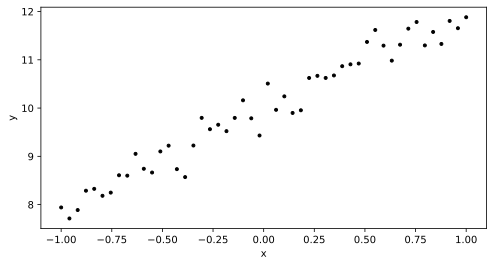

In [16]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

N = 50
x = jnp.linspace(-1, 1, N)
noise = 0.3 * jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,))
y = 2 * x + 10 + noise

data = {"x": x, "y": y}

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(data["x"], data["y"], marker=".", color="black")
ax.set(xlabel="x", ylabel="y")

Next, we define the linear model, the loss function, and a function that performs gradient descent:

In [17]:
def linear_model(params: dict, x: jax.Array) -> jax.Array:
    return params["slope"] * x + params["offset"]


def mse_loss(params: dict, data: dict) -> jax.Array:
    prediction = linear_model(params, data["x"])
    return jnp.mean((data["y"] - prediction) ** 2)


@jax.jit
def gradient_descent_step(params: dict, data: dict, lr: float = 0.1) -> dict:
    grads = jax.grad(mse_loss, argnums=0)(params, data)
    return {key: params[key] - lr * grads[key] for key in params}


def gradient_descent(
    initial_params: dict, data: dict, lr: float = 0.1, num_steps: int = 50
) -> dict:
    """Performs multiple steps of gradient descent."""
    params = initial_params.copy()

    for _ in range(num_steps):
        params = gradient_descent_step(params, data, lr)

    return params

Note that we pass the model parameters, `params`, as a dictionary, but retain the ability to compute gradients with respect to this argument.

Now, we can perform 50 steps of gradient descent and inspect the result:

slope: 2.01, offset: 9.96


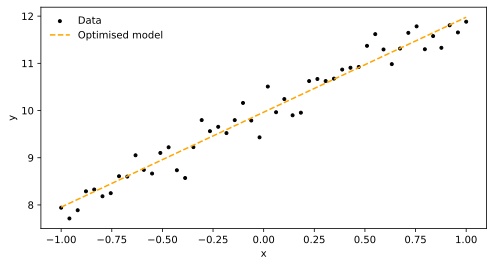

In [18]:
initial_params = {"slope": jnp.array([1.0]), "offset": jnp.array([0.0])}

params = gradient_descent(initial_params, data, lr=0.1, num_steps=50)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(data["x"], data["y"], marker=".", color="black", label="Data")
ax.plot(
    data["x"],
    linear_model(params, data["x"]),
    ls="dashed",
    color="orange",
    label="Optimised model",
)
ax.set(xlabel="x", ylabel="y")
ax.legend(loc="upper left", frameon=False)

print(f"slope: {params['slope'][0]:<.2f}, offset: {params['offset'][0]:<.2f}")

Although a model with only two scalar parameters does not necessitate the usage of a dictionary,
it is not hard to imagine a more complex model with many parameters of various shapes where it
is very convenient to apply transformations across the entire structure while maintaining the nested hierarchy.


## Sources and Further Resources

The above tutorial is largely based on [JAX's comprehensive documentation](https://jax.readthedocs.io/en/latest/index.html). For those eager to delve deeper into the intricacies of JAX, we highly recommend exploring this further, as it offers detailed explanations, examples, and advanced techniques to enrich your understanding and mastery of JAX's capabilities.
